In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2


In [11]:

# --- Load model ---
model = tf.keras.models.load_model("pretrained_model/Resnet50.keras")  # <- Update path


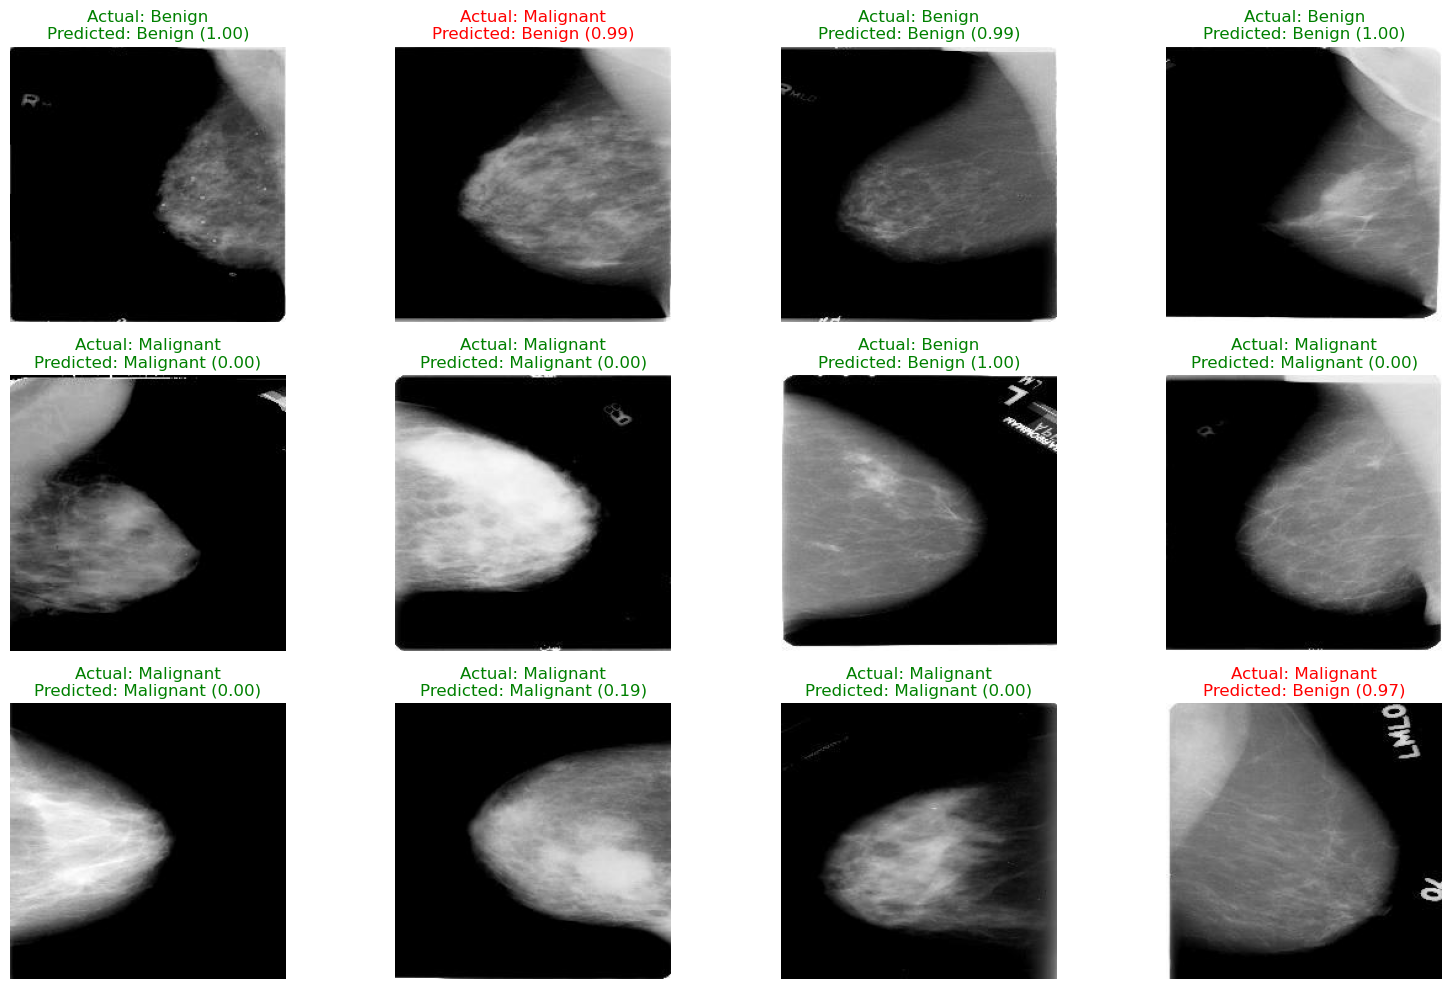

In [15]:

# --- Base directory ---
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"

# --- Parameters ---
img_size = (224, 224)
num_samples = 12

# --- OPTIONAL: Uncomment for reproducible results
# random.seed(42)

# --- Collect image paths and labels ---
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder_path = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(int(label_folder))

# --- Random sample ---
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# --- Preprocessing + Prediction ---
def preprocess(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

predictions = []
original_imgs = []

for img_path in sample_paths:
    input_arr, orig = preprocess(img_path)
    pred = model.predict(input_arr, verbose=0)[0][0]
    predictions.append(pred)
    original_imgs.append(orig)

# --- Plotting ---
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(original_imgs[i])
    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()


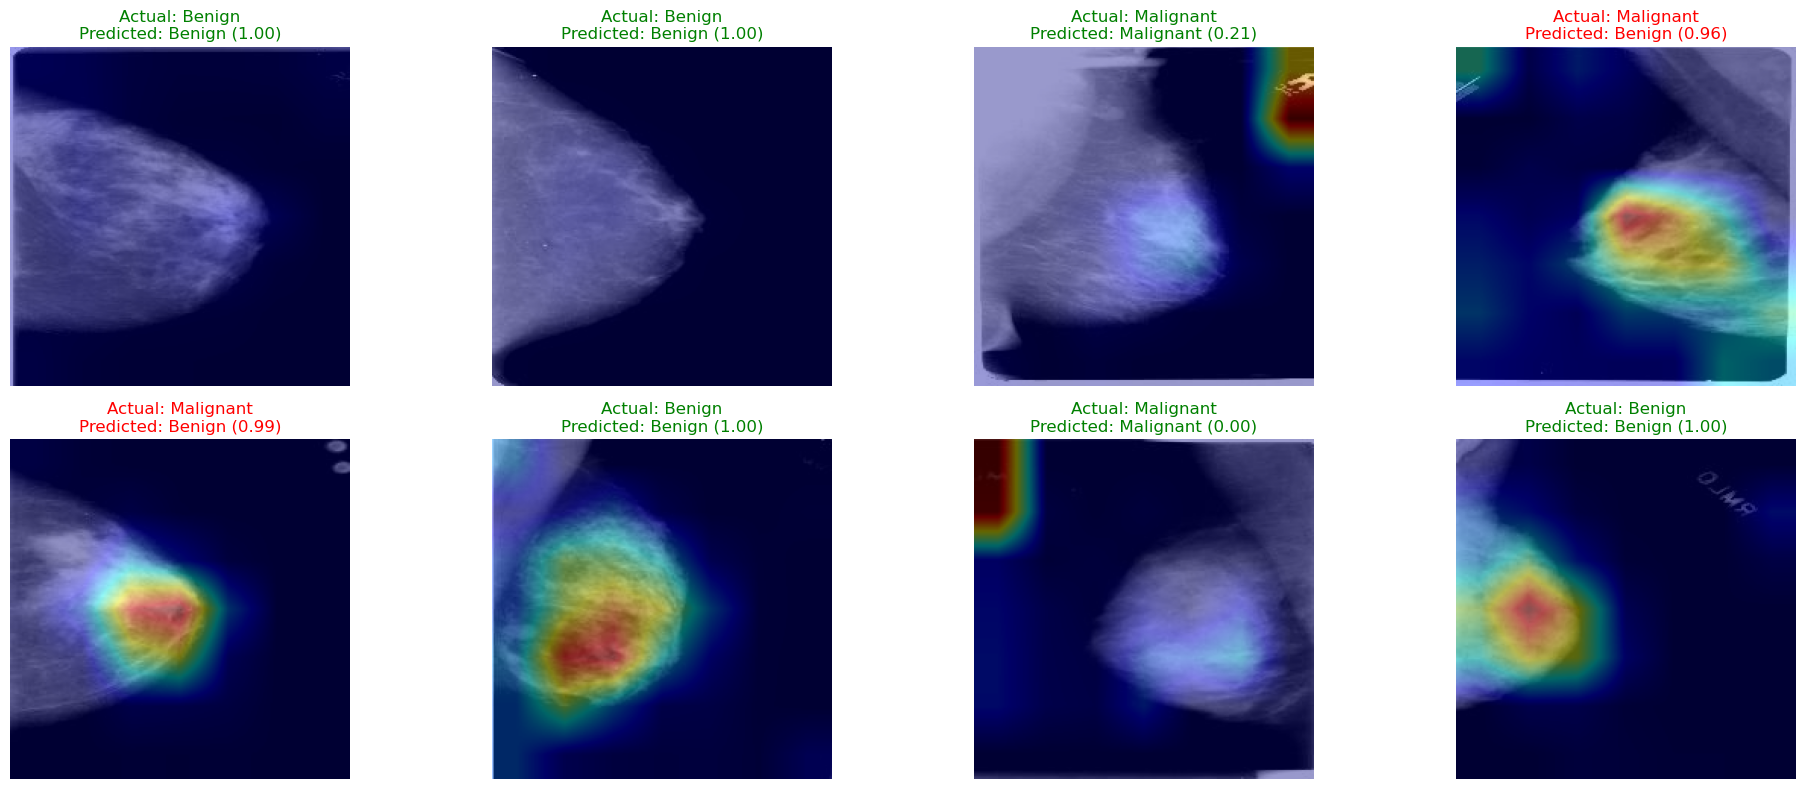

In [17]:
# === Configuration ===
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"
img_size = (224, 224)
num_samples = 8  # Grid: 2 rows x 4 columns

# === Grad-CAM Helper ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out'):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]  # For sigmoid/binary

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

# === Overlay Helper ===
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

# === Collect images & labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))

# === Sample random images ===
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# === Predict and Grad-CAM ===
predictions, overlays = [], []

for img_path in sample_paths:
    # Preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    input_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    input_array = np.expand_dims(input_array, axis=0)

    # Predict
    prob = model.predict(input_array, verbose=0)[0][0]
    predictions.append(prob)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name='conv5_block3_out') #vgg16 = block5_conv3 ; resnet = conv5_block3_out
    overlay = overlay_gradcam_on_image(img_path, heatmap)
    overlays.append(overlay)

# === Plotting ===
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    overlay_rgb = cv2.cvtColor(overlays[i], cv2.COLOR_BGR2RGB)
    plt.imshow(overlay_rgb)

    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = "green" if actual == predicted else "red"
    
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()